In [262]:
from utils import *
from collision import *

%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HOMEWORK 4 -- Reinforcement Learning

In this homework assignment we will add reinforcement learning to our particle simulation! I have added the outside loop to the environment function, you do not need to modify that function. 

You will need to add code to a the relevant agent functions, more details are discussed below

I have provided the RL environment code below, you should at the "advance" function, which as usual contains the main logic for running the simulation. In addition, I removed the impact of the temperature field on the particles velocity, and changed the base-class code so that background particles (food) have no velocity. The goal of this was to help RL agents learn the task, since it requires many examples for agents to learn, especially when there is alot of noise (e.g. from the environment) in the motion of the particles. 

The main goal of this homework is for you to write reinforcement learning code that helps the agent learn how to move in the environment. In this case, we are only trying to train the agent to eat food, so it should move in the direction where it "senses" the maximum amount of food. One important takeaway is that even though we will set up the learning problem with a state space that is very geared towards this solution, it is still a difficult solution for the agent to learn. It's much easier to just hard code that action selection policy! This makes an important point very clear: if its possiblefor a policy to be hardcoded by an agent, as opposed to learned online through reinforcement learning, it almost certainly should be!

Scroll below the next cell for instructions about how to set up the state space, and answer questions 0-3!

In [305]:
class RL_environment(Simulation):
    #this is our interaction! The environment changes temperature and motion of the particle
    def update_velocity(self, p, x_ind, y_ind):
        if len(self.srf["field"].shape) > 2:
            vx = .02*self.srf["field"][0, x_ind, y_ind]
            vy = .02*self.srf["field"][1, x_ind, y_ind]
            
            p.vx, p.vy = p.vx + vx, p.vy + vy
        #no environemntal interactions    
        elif len(self.srf["field"].shape) == 2:
            if self.srf.field[x_ind, y_ind] > 0:
                p.v = 1.00*p.v #+ .15self.srf.field[x_ind, y_ind]*self.dt
            if self.srf.field[x_ind, y_ind] < 0:
                p.v = 1.00*p.v #+ .01*self.srf.field[x_ind, y_ind]*self.dt    
        else:
            pass

    def handle_collisions(self, p = None):
        """Detect and handle any collisions between the Particles.

        When two Particles collide, they do so elastically: their velocities
        change such that both energy and momentum are conserved.

        """ 

        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(range(self.n), 2)
        reward = 0
        
        if p is None:
            for i,j in pairs:
                if self.particles[i].overlaps(self.particles[j]):
                    self.change_velocities(self.particles[i], self.particles[j])
        else:
            for j in range(1, self.n):
                if p.overlaps(self.particles[j]):
                    reward = 1
        return reward

        
    def update_particle_grid(self):
        particle_grid = np.zeros_like(self.srf.field)
        particle_xy_list = np.array([self.get_grid_inds(p) for p in self.particles[1:]])
        particle_grid[particle_xy_list[:, 0], particle_xy_list[:, 1]] = 1.0 
        self.particle_grid = gaussian_filter(particle_grid, sigma = 5)
        
    def update_temperature(self, p, x_ind, y_ind):
        if hasattr(p, 'temperature'): 

            if len(self.srf.field.shape) > 2:
                p.temperature = p.temperature + (np.hypot(*self.srf.field[:, x_ind, y_ind]) - 2.0) 

            elif len(self.srf["field"].shape) == 2:

                    p.temperature = p.temperature + self.srf.field[x_ind, y_ind]*(self.dt) 

    def update_particle_sensors(self, p, x_ind, y_ind, particle_grid):
        if hasattr(p, 'temperature_state'): 
            if len(self.srf["field"].shape) == 2:
                if hasattr(p, 'sensors'):
                     
                    p.temperature_state[((p.sensors[:, 0] + 2)/2).astype(int), 
                                        ((p.sensors[:, 1] + 2)/2).astype(int)] = self.srf.field[x_ind +
                                                                                                3*p.sensors[:, 0],
                                                                                                y_ind + 
                                                                                                3*p.sensors[:, 1]]
                    
                    #add noise
                    #p.temperature_state = np.random.normal(loc = p.temperature_state, scale = 0)
                    
        if hasattr(p, 'food_state'):
            if len(self.srf["field"].shape) == 2:
                if hasattr(p, 'sensors'):
                    p.food_state[((p.sensors[:, 0] + 2)/2).astype(int), 
                                        ((p.sensors[:, 1] + 2)/2).astype(int)] = particle_grid[x_ind + 
                                                                                               3*p.sensors[:, 0], 
                                                                                               y_ind + 
                                                                                            3*p.sensors[:, 1]]
    def setup_animation(self):
        
        self.fig = plt.figure(figsize = [7, 8]) # axes = plt.subplots(3,2, subplot_kw = {'adjustable' : 'datalim'},
                  #                     gridspec_kw={'height_ratios': [1, 2, 5]}, figsize = [8, 10])
        
        
        self.top_ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=1)
        self.top_ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=1)
        self.ri_ax = plt.subplot2grid((5, 3), (0, 1), colspan=2, rowspan = 2)
        
        self.ax = plt.subplot2grid((5, 3), (2, 0), colspan = 3, rowspan = 3)
       

        self.srf.plot(fig = self.fig, ax = self.ax)

        
        self.ax.set_title("")
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])
        

        self.ri_ax.xaxis.set_ticks([])
        self.ri_ax.yaxis.set_ticks([])

        
        sns.despine(ax = self.ri_ax)
        sns.despine(ax = self.top_ax1, bottom = True, left = True)
        sns.despine(ax = self.top_ax2, bottom = True, left = True)
        sns.despine(ax = self.ax)                                                                                          

        plt.tight_layout()
    def interact(self, p, particle_grid):
            #bounce the particle off the walls
        self.handle_boundary_collisions(p)

        #change the temperature of the agent
        x_ind, y_ind = self.get_grid_inds(p)

        self.update_particle_sensors(p, x_ind, y_ind, particle_grid)

        self.update_velocity(p, x_ind, y_ind)
        #move faster in high temp regions

        self.update_temperature(p, x_ind, y_ind)

               
           # p.v = .95*p.v
        
    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""
        self.ri_ax.cla() # clear the previous image
    
        self.ri_ax.plot(np.array(self.particles[0].temp_log) ,  c = 'r', label = 'temperature')# plot the line
        self.ri_ax.plot(np.array(self.particles[0].food_log) ,  c = 'k', label = 'food store')
        self.ri_ax.legend()
        
        sns.despine(ax = self.ri_ax)
        
        self.top_ax1.cla()
        self.top_ax1.imshow(self.particles[0].temperature_state.transpose(1, 0), origin = "lower", vmin = -2, vmax = 6)
        
        #self.top_ax1.set_title("x: " + str(np.round(self.particles[0].x_temp, 1)) + "\n" + str(np.round(self.particles[0].y_temp, 1)))
                               
        sns.despine(ax = self.top_ax1, bottom = True, left = True)
        
        
        self.top_ax2.cla()
        self.top_ax2.imshow(self.particles[0].food_state.transpose(1, 0), cmap = 'pink', vmin = 0, vmax = .1, origin = "lower")
        
        self.top_ax2.set_title("food sensors")
        
        sns.despine(ax = self.top_ax2, bottom = True, left = True)
        
        self.top_ax1.xaxis.set_ticks([])
        self.top_ax1.yaxis.set_ticks([])
        self.top_ax2.xaxis.set_ticks([])
        self.top_ax2.yaxis.set_ticks([])
        
        self.advance_animation()
        
        return self.circles
                
    def advance(self):
        """Advance the animation by dt."""
        self.update_particle_grid()
        for i, p in enumerate(self.particles):
            if p.delete:
                self.particles.remove(p)
                self.n -=1
            else:
                if hasattr(p, 'Q_table'):   
                    state = p.get_state()
                    action = p.advance(self.dt)
                    reward = self.handle_collisions(p)
                    self.interact(p, self.particle_grid)
                    next_state = p.get_state()
                    p.update_Qtable(state, action, reward, next_state)
                else:    
                    p.advance(self.dt)
                    self.interact(p, self.particle_grid)
 
        
        self.handle_collisions()

        
    def advance_animation(self):
        """Advance the animation by dt, returning the updated Circles list."""        
        
        self.update_particle_grid()
        for i, p in enumerate(self.particles):
           #clean up the eaten food 
    
            if p.delete:
                self.particles.remove(p)
                self.n -=1
                self.circles[i].radius = 0
                self.circles.pop(i)
                
            else:
                if hasattr(p, 'Q_table'):   
                    state = p.get_state()
                    action = p.advance(self.dt)
                    reward = self.handle_collisions(p)
                    self.interact(p, self.particle_grid)
                    next_state = p.get_state()
                    p.update_Qtable(state, action, reward, next_state)
                else:    
                    p.advance(self.dt)
                    self.interact(p, self.particle_grid)
 
                try:
                    self.circles[i].set_xy = p.r
                except:
                    pass
                
        self.handle_collisions()
        self.update_particle_grid()
        
        self.circles[0].remove()
        self.circles[0] = self.particles[0].draw(self.ax)    
        
               
        return self.circles

# setting up our RL agent.

0. Setting up the state space:

In the __init__() function below, you will have to define a Qtable, and a list of actions. 

In general, in a tabular setting, a state space is the set of all possible "states" an agent can be in. In our case, that would be the outer product of the food sensors, and some discretization on their possible activations. We will massively simplify this by defining a state space which is the same shape and size as food_sensors. We will interpret the state occupied as the direction of maximum food. for example, if we had a 2 x 2 sensor array, our state space woul dlook like [[0, 0], [0, 0]]. If the food_sensors were: [[5, 4], [2, 4]], we would detect a maximum amount of food to the top left of our sensor grid, so our state space would be [[1, 0], [0, 0]]. 

Similarly, we will have an action space that allows the particle to move in each of the directions defined by the sensor_state. So if the maximum food was in the top left, we would want to move in the direction [-1, -1]. We want movement directions where the index in the actions list maps on to a location on the food sensor grid. That is, if I found a linear index into food_sensors with ind = np.argmax(food_sensors) (remember argmax doesnt return 2-D matrix indices, but rather the linerized index), I want to be able to take act = actions[ind], and that action would move me in the direction of maximum food. This definition of the list of actions should be nearly identical to the self.sensors list, that is a list of [x, y] tuples that defines a particle-centric direction. 


i. define the variable self.Q_table. Self.Q_table should be intialized to small random numbers, and should have shape state_space.shape[0], state_space.shape[1], x len(self.actions). In this case we have a 2D state space, so the first 2dimensions of the Qtable are related to the x, y state dimensions, and the 3rd dimension is for all possible actions. 
Concretely, this means we will learn one Q-value for the outer product of every state, and every action. This lets us chose the best possible action in each state. 

ii. define the variable self.actions, as discussed above. 

1. fill in the code for agent.get_state() -- remember as we discussed above the state is the direction of maximum sensed particles on the particle_state grid. You might find np.unravel_index() helpful, since you should return a 2D index, not a linear index. 

2. fill in the code for agent.choose_action(). This should use an epsilon greedy exploration policy and be nearly identicle to what I showed in class for the simplified agent. 

3. fill in the code for agent.move().

4. fill in the code for agent.advance(). This is now very simplified and should simply choose and action, move, and exist, then return the chosen action. 

5. fill in the code for agent.update_Qtable(). This should also be almost identicle to what we did in the demo lecture!


Your code in this notebook is your deliverable. You should also write a small paragraph about other possible state-space choices we could have made, and the strategy learned by your agent, and turn that in with your code. 

EXTRA CREDIT:

If you want to learn feature weights using function approximation on the food_sensors, that would be +5 pts extra credit! That is, an extra 20%. But user be warned, I havent tried that in this code :-). 

If you want to add back in any of the homeostasis action selection policies, dying from over heating, or even doing RL on the homeostasis objective (e.g. you get a + 1 reward if you are within your margin, a -1 reward otherwise), using the temperature sensors grid in the same way we used food_sensors here as a statespace, that would give you an extra +5 points extra credit as well. We will use our judgement about whether we think you put in an extra 20% work, this is open ended!

In [338]:
class RL_agent(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x = .5, y = .5, vx = 0, vy=0, radius = .05, styles = 
                 {'edgecolor': 'k', 'linewidth': 2, 'alpha': 1, 'facecolor': 'k'} , 
                 food_store = 100, n_sensors = 3, lr = .01, discount = .99):
        
        self.r = np.array((x, y)).astype('float32')
        self.v = np.array((vx, vy)).astype('float32')
        self.n_sensors = n_sensors
        
        #sensors
        self.temperature_state = np.zeros([n_sensors, n_sensors])
        self.food_state = np.zeros([n_sensors, n_sensors])
        
        self.Q_table = #your code goes here
        
        
        self.epsilon = .7
        self.learning_rate = lr
        self.discount = discount
        
        pairs = list(product(range(n_sensors), range(n_sensors))   )  
        self.sensors = (np.array([[i, j] for i, j in pairs]) - 1)*2
        
        #we interpret this as directions to change velocity
        self.actions = #your code goes here
        
        
         
        self.hidden_radius = radius
        self.radius = 1.5*radius
        self.mass = self.radius**2
        self.delete = False
        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'c', 'fill': False}
        
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin =  .1
         

        self.temp_log = []
        self.food_log = []
        self.grad_log = []
        
        self.x_temp = 0
        self.y_temp = 0

        
    
    def get_state(self):
        return #your code goes here
        
    
    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Path.circle(center = self.r, radius = self.hidden_radius)#Circle(xy=self.r, radius=self.radius, **self.styles)    
        patch = patches.PathPatch(circle, facecolor = None, lw=2, path_effects=[
        patheffects.withTickedStroke(angle=-90, spacing=8, length=2)]);
        ax.add_patch(patch)
        
        return patch
            
    def exist(self, dt):
        
        self.grad_log.append(np.sign(self.v[0]))
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)

        self.v = .5*self.v
             
    def move(self, dt, action):
         #your code goes here! Move in the direction of self.actions[action]
        
        self.r += self.v * dt   
        

#you dont have to change anything above this line!!#
    def overlaps(self, other):
        """Does the circle of this Particle overlap that of other?"""
        overlap = np.hypot(*(self.r - other.r)) < (self.radius + other.radius)
        
        #new
        if overlap:
            other.delete = True
            other.radius = 0
            self.food_store += 1
            
        return overlap
        
    
    def map_sensor(self, intx, inty):
        '''takes positions on a sensor grid and returns direction
        '''
        grid = .05*self.sensors.reshape(self.n_sensors, self.n_sensors, 2)
         
        return grid[intx, inty]

            
    def update_Qtable(self, state, action, reward, new_state):
        '''
        state[0] = x position of max sensor location
        state[1] = y position of max sensor location

        '''


       
    def choose_action(self, state):
        
        
        #your code goes here
        
        return action
    
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #your code goes here
        
        return 


# train your agent

heres some code to train your agent. Notice we dont reinitialize the agent, so the Q-table persists, and we got rid of all the code in the agent for it to die based on temperature, etc. 

some hints:

1. as usual you should watch your simulation before running long training episodes, to make sure everything makes sense.
2. it can be very helpful to manually code in the action selection policy that you think is optimal, and then make sure everything goes according to plan, this is a good way to spot check your code! E.g act_ind = np.argmax(food_state)
3. by visualizing the Q_table, you can understand the policy the agent is learning! E.g. for Q_table[0, 0, :] there should be a high value for the action 0. For Q_table[0, 1, :] there should be a high value for the action 1, etc. 
4. Good luck! We dont expect you to learn a perfect Q_table, that takes a tonne of time! It's sufficient to have working code that correctly instantiates the state space, and Q_table, etc. 

In [339]:
srf = generate_tempgrad(scale = .01)

sim = RL_environment(n = 100, radius= [np.random.uniform(0, .01) for i in range(100)], srf = srf)
p = RL_agent(vx = 0, vy = 0)

sim.particles.insert(0, p)


In [ ]:

lifetime = 50
n_episodes = 10

for episode in range(n_episodes):
    sim = RL_environment(n = 50, radius= [np.random.uniform(0, .01) for i in range(50)], srf = srf)
    sim.particles.insert(0, p)
    
    i = 0
    while (len(sim.particles) > 5) & (i*sim.dt < lifetime):
        sim.advance()
        i+=1
        

<IPython.core.display.Javascript object>


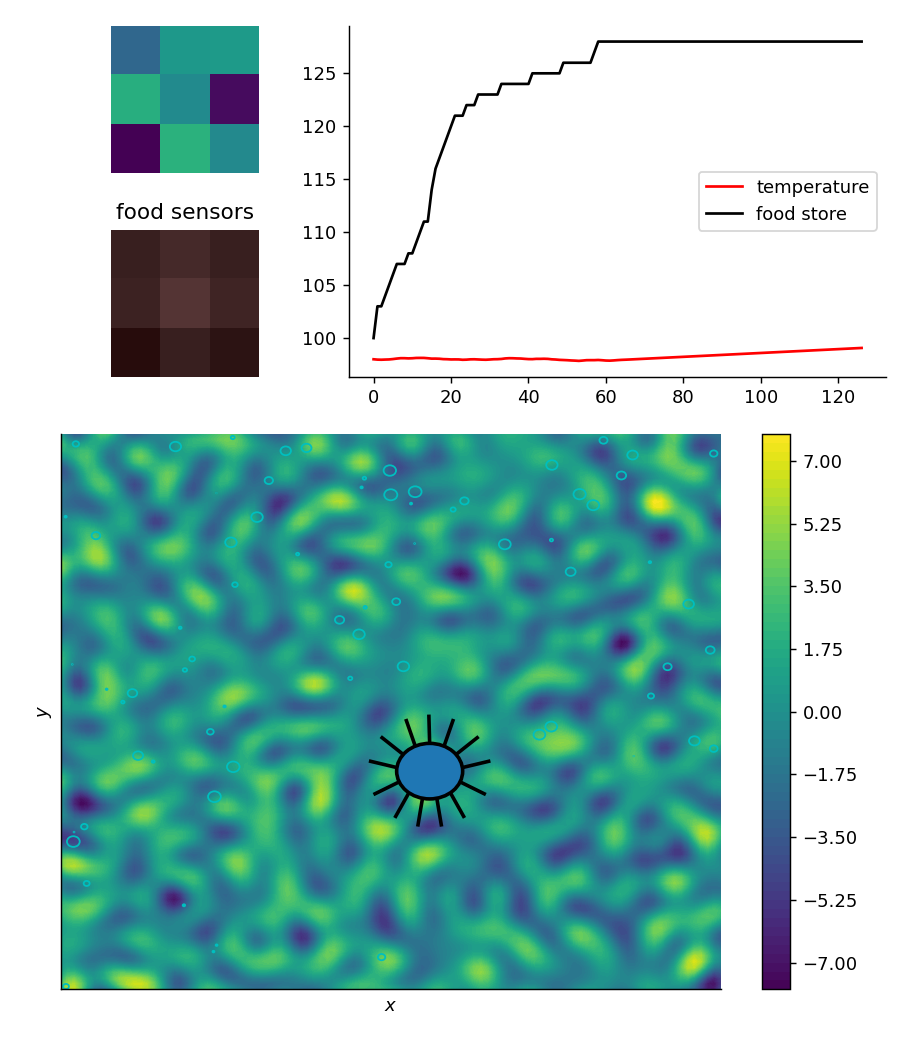

In [316]:
%matplotlib notebook

sim.do_animation(save=False)

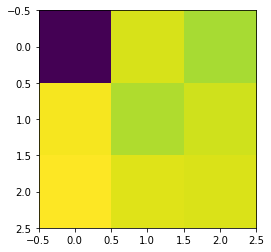

In [345]:
%matplotlib inline
plt.imshow(p.Q_table[:, :, 3])